In [1]:
from Algorithm import Gaussian_Process
from Algorithm import LA_Bayessian_Quadrature
from Algorithm import Mesh
from Algorithm import Kernels


import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

plt.rcParams['figure.figsize'] = [12, 6]


In [2]:
class Option:
    def __init__(self, opt_type, underlying, strike, maturity,position, multiplier=1.0):
        self.opt_type = opt_type        # str: 'call' or 'put' 看涨/看跌
        self.underlying = underlying    # int: option index 期权索引
        self.strike = strike            # float: strike price 期权执行价
        self.maturity = maturity        # float: expiry date(yr) 期权到期时间（年）
        self.position = position        # int: + long, – short 仓位（+ 多，- 空）
        self.multiplier = multiplier    # float: contract multiplier 合约乘数

    # Black‑Scholes analytic delta (for demonstration / benchmark)
    def analytic_delta(self, S0, vol, r):
        T = self.maturity
        d1 = (np.log(S0 / self.strike) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
        if self.opt_type.lower() == "call":
            return norm.cdf(d1)
        else:  # put
            return norm.cdf(d1) - 1.0

    # Integrand for MC/BQ given path value ST_i
    def delta_integrand(self, ST_i, S0_i, discount):
        if self.opt_type.lower() == "call":
            g = (ST_i > self.strike) * (ST_i / S0_i)
        else:  # put
            g = (-1) * (ST_i < self.strike) * (ST_i / S0_i)
        return discount * g


# ---------- 2. Portfolio allowing heterogeneous maturities ----------
class OptionPortfolio:
    def __init__(self, options):
        self.options = options

    def analytic_delta(self, S0_vec, vol_vec, r):
        """Exact BS portfolio delta via linearity (handles different T)."""
        total = 0.0
        for opt in self.options:
            S0_i = S0_vec[opt.underlying]
            vol_i = vol_vec[opt.underlying]
            delta_i = opt.analytic_delta(S0_i, vol_i, r)
            total += opt.position * opt.multiplier * delta_i
        return total


# ---------- 3. Path‑wise portfolio Δ given one Gaussian vector ----------
def pathwise_portfolio_delta(Z, *, S0_vec, vol_vec, corr, r, portfolio):

    # Correlate the normals
    L = np.linalg.cholesky(corr)
    Z_corr = L @ Z

    total = 0.0
    for opt in portfolio.options:
        idx = opt.underlying
        S0_i = S0_vec[idx]
        vol_i = vol_vec[idx]
        T_i   = opt.maturity

        # Brownian property: same Z drives all maturities
        ST_i = S0_i * np.exp((r - 0.5 * vol_i ** 2) * T_i +
                             vol_i * np.sqrt(T_i) * Z_corr[idx])

        discount = np.exp(-r * T_i)
        g = opt.delta_integrand(ST_i, S0_i, discount)
        total += opt.position * opt.multiplier * g

    return total


# ---------- 4. Demo with heterogeneous maturities ----------
# Market data
S = np.array([98.0])
vol = np.array([0.25])
corr = np.eye(len(S))
r = 0.03

# Two‑option portfolio
opt1 = Option('call', 0, 95, 1.0,  15, 1)   # 6‑month call, long 10
portfolio = OptionPortfolio([opt1])

# Analytic portfolio Δ (exact BS, linear combination)
price_min = 50
price_max = 150

def func(S):
    if np.isscalar(S):
        S = [S]
    S_initial = [ini(i) for i in S]
    return portfolio.analytic_delta(S_initial, vol, r)

# Monte Carlo / placeholder for adaptive BQ
rng = np.random.default_rng(0)
n_samples = 150_000
Z_samples = rng.standard_normal((n_samples, len(S)))
vals = np.apply_along_axis(pathwise_portfolio_delta, 1, Z_samples,
                           S0_vec=S, vol_vec=vol, corr=corr, r=r, portfolio=portfolio)
delta_mc  = vals.mean()
stderr_mc = vals.std(ddof=1) / np.sqrt(n_samples)

def oti(price):
    return (price-price_min)/(price_max - price_min)

def ini(price):
    return price_min + price * (price_max - price_min)


print(f"Analytic portfolio Δ : {func([oti(98.0),oti(98.0)]):,.4f}")
print(f"Monte Carlo estimate : {delta_mc:,.4f} ± {stderr_mc:.4f} (1σ)")

Analytic portfolio Δ : 9.6611
Monte Carlo estimate : 9.6605 ± 0.0234 (1σ)


[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150.]


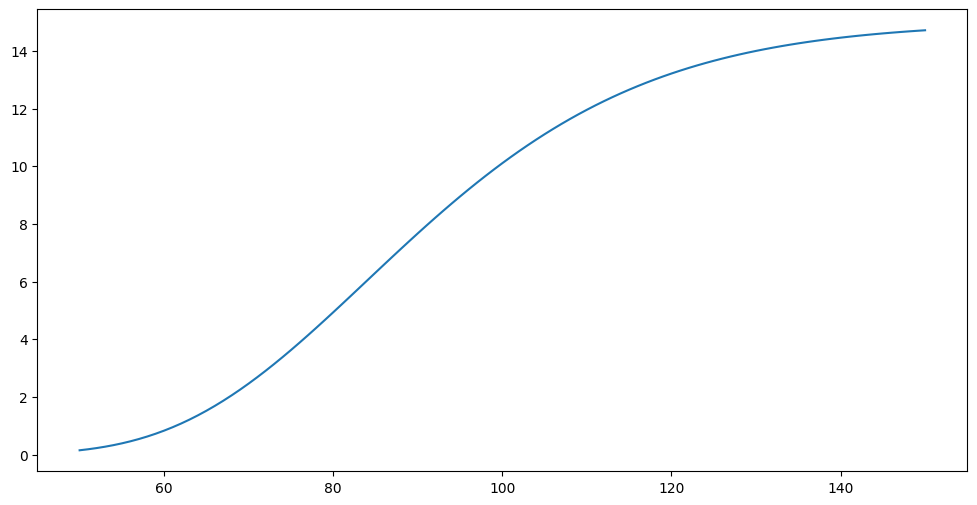

In [6]:
a = np.linspace(50, 150, 101)
b = np.zeros_like(a)
for i in range(101):
    b[i] = func(oti(a[i]))

plt.plot(a,b)
plt.show()

In [15]:
X = np.around(np.array(np.meshgrid(np.linspace(0,1,11), indexing='ij')).reshape(1,-1).T,1)
print(X)
Y = []
for i in range(11):
    Y.append(func(X[i]))
print(Y)
beta = np.array([-0.33, -1, -0.9, -1, -1.2, -2, -2.6, -2, -1.2, -1, -1.1, -1])

[[0. ]
 [0.1]
 [0.2]
 [0.3]
 [0.4]
 [0.5]
 [0.6]
 [0.7]
 [0.8]
 [0.9]
 [1. ]]
[np.float64(0.1515792835577107), np.float64(0.8334838771494726), np.float64(2.4660268024005703), np.float64(4.936492766068035), np.float64(7.671907196332887), np.float64(10.105608186827828), np.float64(11.95695111620472), np.float64(13.213385306873368), np.float64(13.997173416437), np.float64(14.456365219701512), np.float64(14.713032698263564)]


In [16]:
GP = Gaussian_Process.GaussianProcess(Kernels.K_lin_mat2_10,beta,X,Y) # Define Gaussian process

In [17]:
GPs_mat1,int_params_mat1 = LA_Bayessian_Quadrature.ABC(func,GP,Mesh.get_points,30,[30,1])


Step:  1  /  31
Step:  2  /  31
Step:  3  /  31
Step:  4  /  31
Step:  5  /  31
Step:  6  /  31
Step:  7  /  31
Step:  8  /  31
Step:  9  /  31
Step:  10  /  31
Step:  11  /  31
Step:  12  /  31
Step:  13  /  31
Step:  14  /  31
Step:  15  /  31
Step:  16  /  31
Step:  17  /  31
Step:  18  /  31
Step:  19  /  31
Step:  20  /  31
Step:  21  /  31
Step:  22  /  31
Step:  23  /  31
Step:  24  /  31
Step:  25  /  31
Step:  26  /  31
Step:  27  /  31
Step:  28  /  31
Step:  29  /  31
Step:  30  /  31
Step:  31  /  31


In [18]:
final_GP = GPs_mat1[-1]
def bs_delta(S, K=95, T=1.0, sigma=0.25, r=0.03, opt_type='call'):
    if T <= 0 or sigma <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if opt_type == 'call':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1.0

def scaled_bs_delta(x):
    S = 50 + 100 * x
    return 15 * bs_delta(S)


I_true, err = quad(scaled_bs_delta, 0, 1)
print("True value =", I_true)
print("Calculated value =", int_params_mat1[-1])

True value = 8.7080319904192
Calculated value = [8.70812413e+00 5.17102698e-08]
